In [1]:
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import datetime

In [48]:
pred_model = pd.read_csv("Pred_Model.csv")

In [49]:
pred_model['start_time'] = pd.to_datetime(pred_model['start_time'])
pred_model['end_time'] = pd.to_datetime(pred_model['end_time'])

In [50]:
pred_model_counts = pred_model.groupby([pd.Grouper(key='start_time', freq = 'H')]).size().to_frame('counts')

In [51]:
pred_model_counts["counts"].sum()

1235121

In [52]:
# make index to column to create day of week and month based on date
pred_model_counts['index1'] = pred_model_counts.index
pred_model_counts["hourofday"] = pred_model_counts["index1"].dt.hour
pred_model_counts["weekday"] = pred_model_counts["index1"].dt.dayofweek
pred_model_counts["month"] = pred_model_counts["index1"].dt.month

In [53]:
pred_model_counts = pred_model_counts.drop('index1', axis=1)

In [54]:
pred_model_counts.index.names = ['daytime']
pred_model_counts.index = pd.to_datetime(pred_model_counts.index)
pred_model_counts

,counts,hourofday,weekday,month
daytime,,,,
2016-01-01 00:00:00,13,0,4,1
2016-01-01 01:00:00,14,1,4,1
2016-01-01 02:00:00,9,2,4,1
2016-01-01 03:00:00,1,3,4,1
2016-01-01 04:00:00,0,4,4,1
...,...,...,...,...
2016-12-31 19:00:00,20,19,5,12
2016-12-31 20:00:00,13,20,5,12
2016-12-31 21:00:00,22,21,5,12


## Import weather and merge with pred_model_counts

In [55]:
weather_hourly = pd.read_csv('weather_hourly.csv')
weather_hourly.head()

,Unnamed: 0,max_temp,min_temp,precip,interp_maxtemp,interp_mintemp,interp_precip,update_maxtemp,update_mintemp,update_precip
0,2015-01-01 06:00:00,-5.6,-5.6,0.0,-5.6,-5.6,0.0,-5.6,-5.6,0.0
1,2015-01-01 07:00:00,-5.6,-5.6,0.0,-5.6,-5.6,0.0,-5.6,-5.6,0.0
2,2015-01-01 08:00:00,-5.6,-5.6,0.0,-5.6,-5.6,0.0,-5.6,-5.6,0.0
3,2015-01-01 09:00:00,-4.4,-4.4,0.0,-4.4,-4.4,0.0,-4.4,-4.4,0.0
4,2015-01-01 10:00:00,-5.6,-5.6,0.0,-5.6,-5.6,0.0,-5.6,-5.6,0.0


In [56]:
weatherhour = weather_hourly.drop(columns = ['max_temp','min_temp','precip','interp_maxtemp','interp_mintemp','interp_precip'])
weatherhour['temp_av'] = (weatherhour['update_maxtemp'] + weatherhour['update_mintemp']) / 2
weatherhour = weatherhour.drop(columns = ['update_mintemp', 'update_maxtemp'])
weatherhour = weatherhour.set_index('Unnamed: 0')
weatherhour.index.names = ['daytime']
weatherhour.index = pd.to_datetime(weatherhour.index)
weatherhour

,update_precip,temp_av
daytime,,
2015-01-01 06:00:00,0.0,-5.6
2015-01-01 07:00:00,0.0,-5.6
2015-01-01 08:00:00,0.0,-5.6
2015-01-01 09:00:00,0.0,-4.4
2015-01-01 10:00:00,0.0,-5.6
...,...,...
2020-01-02 01:00:00,0.0,3.3
2020-01-02 02:00:00,0.0,3.3
2020-01-02 03:00:00,0.0,2.8


In [57]:
weatherhour.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43848 entries, 2015-01-01 06:00:00 to 2020-01-02 05:00:00
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   update_precip  43848 non-null  float64
 1   temp_av        43848 non-null  float64
dtypes: float64(2)
memory usage: 1.0 MB


In [58]:
weatherhour = weatherhour.loc['2016-01-01 00:00:00' : '2017-01-01 00:00:00']
weatherhour

,update_precip,temp_av
daytime,,
2016-01-01 00:00:00,0.0,5.6
2016-01-01 01:00:00,0.0,5.0
2016-01-01 02:00:00,0.0,5.0
2016-01-01 03:00:00,0.0,4.4
2016-01-01 04:00:00,0.0,4.4
...,...,...
2016-12-31 20:00:00,0.0,1.7
2016-12-31 21:00:00,0.0,1.7
2016-12-31 22:00:00,0.0,2.2


In [59]:
pred_model_joint = pred_model_counts.join(weatherhour, how="left")
pred_model_joint

,counts,hourofday,weekday,month,update_precip,temp_av
daytime,,,,,,
2016-01-01 00:00:00,13,0,4,1,0.0,5.6
2016-01-01 01:00:00,14,1,4,1,0.0,5.0
2016-01-01 02:00:00,9,2,4,1,0.0,5.0
2016-01-01 03:00:00,1,3,4,1,0.0,4.4
2016-01-01 04:00:00,0,4,4,1,0.0,4.4
...,...,...,...,...,...,...
2016-12-31 19:00:00,20,19,5,12,0.0,1.7
2016-12-31 20:00:00,13,20,5,12,0.0,1.7
2016-12-31 21:00:00,22,21,5,12,0.0,1.7


To Do
- Bike data indexieren
- bereinigen
- groupby.dt.hour.size()
- mergen
- Holdout/Training Split

Variables

- Time of the day in hours 
- Month
- Weekday (0-6)
- Temperature (average of min and max temp cause very similar)
- Precipitation (0,1)

Models

- Polynomial (lasso/...)
- Random Forest
- Neural Networks

In [84]:
from sklearn.model_selection import train_test_split

# Extract the relevant features from the dataset
X = pred_model_joint[['hourofday', 'weekday', 'month', 'update_precip', 'temp_av']]
y = pred_model_joint['counts']

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

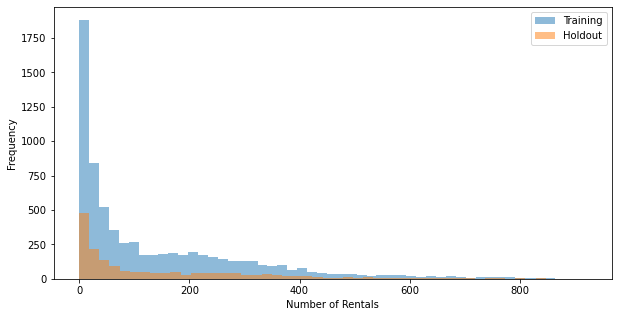

In [85]:
# Plot the distribution of the target variable in the training and holdout sets
plt.figure(figsize=(10, 5))
plt.hist(y_train, bins=50, alpha=0.5, label='Training')
plt.hist(y_test, bins=50, alpha=0.5, label='Holdout')
plt.xlabel('Number of Rentals')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**Random Forest**

In [90]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

# Define the parameter grid for the Random Forest model
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [2, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Use RandomizedSearchCV to perform hyperparameter tuning
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=10, cv=5, n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best parameters from the search
best_params = random_search.best_estimator_.get_params()
print("Best parameters found: ",best_params)

Best parameters found:  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [91]:
# Use the best parameters to create a new model
best_rf_model = RandomForestRegressor(random_state=42, **random_search.best_params_)

# Fit the new model to the training data
best_rf_model.fit(X_train, y_train)

# Make predictions on the holdout set
y_pred = best_rf_model.predict(X_test)

# Evaluate the new model's performance on the holdout set
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)
print("R-squared: ", r2)

Mean Squared Error:  2147.7500762154123
Mean Absolute Error:  26.23946473968073
R-squared:  0.9283358632489239


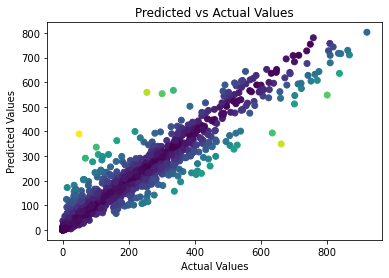

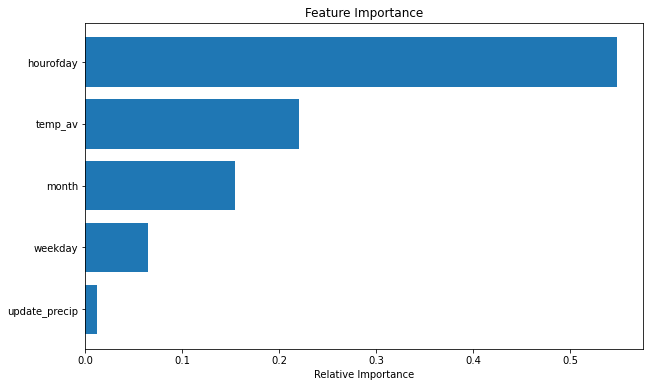

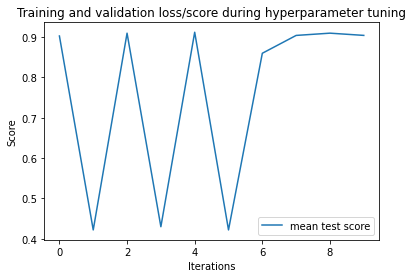

In [96]:
# Create an array of colors based on the difference between the predicted and actual values
colors = np.abs(y_test - y_pred)

# Plot the predicted vs actual values on the holdout set
plt.scatter(y_test, y_pred, c=colors)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()

# Plot the distribution of the feature importances
importances = best_rf_model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)
plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

# plot the training and validation loss/score during hyperparameter tuning
plt.plot(random_search.cv_results_['mean_test_score'], label = 'mean test score')
plt.xlabel('Iterations')
plt.ylabel('Score')
plt.title('Training and validation loss/score during hyperparameter tuning')
plt.legend()
plt.show()